In [151]:
# Import packages
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno

In [152]:
# Set output file destination
file_dest = os.getcwd()

# Web Scraping Historic ADP Data (2013 - 2021)

In [153]:
def myleague_adp_data(year):
    '''
    Function to scrape ADP (average draft position) data from https://api.myfantasyleague.com/
    This returns all players who were drafted in at least 5% of leagues
    '''
    # Remove warnings
    pd.options.mode.chained_assignment = None
    
    # URL constants
    base_url = 'https://api.myfantasyleague.com/'
    url_spec = '/reports?R=ADP&POS=RB%2BWR%2BTE&ROOKIES=0&CUTOFF=5&FCOUNT=0&IS_PPR=1&IS_KEEPER=N&IS_MOCK=1&PERIOD=AUG15'
    
    # Extract table HTML from input URL
    page = requests.get(base_url + str(year) + url_spec + '&PAGE=ALL')
    soup = BeautifulSoup(page.text, 'lxml')
    table = soup.find('table', attrs={'class': 'report'})
    
    # Convert table HTML to pandas df and clean up
    df = pd.read_html(str(table))[0]
    df.drop(df.tail(1).index, inplace=True) # Drop last row (Page: 1 2 3 4 ALL)
    df['Year'] = year
    df['ADP'] = df['Avg Pick'].astype(float)                                     # Rename column and force to float
    df[['LastName', 'Player']] = df.Player.str.split(", ", expand=True)          # Expand player info across columns
    df[['FirstName', 'Team', 'Position']] = df.Player.str.split(expand=True)     # Ex: McCaffrey, Christian CAR RB
    df['FirstName'] = df['FirstName'].str.replace('[^\w\s]', '', regex=True)     # Remove punctuation
    df['LastName'] = df['LastName'].str.replace('[^\w\s]', '', regex=True)
    df = df[['FirstName', 'LastName', 'Team', 'Position', 'ADP', 'Year']]        # Order columns
    df = df[(df.Team != "FA") & (df.Team != "FA*")]                              # Remove free agents
    
    # Convert team names for consistency
    team_conv = {
        'GBP': 'GNB', 'JAC': 'JAX', 'KCC': 'KAN', 'NOS': 'NOR', 
        'NEP': 'NWE', 'RAM': 'LAR', 'SDC': 'SDG', 'TBB': 'TAM'
    }
    
    df = df.replace({'Team': team_conv})
    
    return df


In [154]:
def add_competition_data(adp_df):
    '''
    Function to get positional competition data for each player, including
        - Positional rank on team
        - ADP of teammates in same position
        - Positional ambiguity (T/F)
        - Handcuff (T/F) - not yet added
    '''
    
    # Remove warnings
    pd.options.mode.chained_assignment = None
    
    teams = list(set(adp_df.Team))
    team_dfs = []
    # Get positional competition data for each team by position
    for team in teams:
        team_pos_dfs = [] # List used to store each positional data frame create for a given team
        positions = ['RB', 'WR', 'TE']
        for position in positions:
            
            # Determine positional ranks of players with same team/position
            pos_team_df = adp_df[(adp_df.Team == team) & (adp_df.Position == position)].reset_index(drop=True)
            pos_team_df["TeamPosRank"] = pos_team_df.index + 1
            pos_team_df["TeamPosRank"] = pos_team_df.Position + pos_team_df.TeamPosRank.astype(str)
            
            # Determine ADPs of the lead and secondary position players on the team
            pos_adps = sorted(pos_team_df.ADP)
            
            # RB1/WR1/TE1 ADP in team will be the first element of pos_adps
            try:
                pos1_adp = pos_adps[0]
            except:
                pos1_adp = np.nan
            
            # RB2/WR2/TE2 ADP in team will be the second element of pos_adps
            try:
                pos2_adp = pos_adps[1]
            except:
                pos2_adp = np.nan
            pos_team_df['PosRank1_ADP'] = pos1_adp
            pos_team_df['PosRank2_ADP'] = pos2_adp
            
            # Determine if team position is ambiguous
            # Ambiguous: Multiple players in a position drafted between rounds 3 through 9
            try:
                ambiguous = (pos1_adp > 24) & (pos1_adp <= 108) & (pos2_adp > 24) & (pos2_adp <= 108)
            except:
                ambiguous = False
            pos_team_df["PosAmbiguity"] = ambiguous
            
            # Append data frame to list
            team_pos_dfs.append(pos_team_df)
            
        team_dfs.append(pd.concat(team_pos_dfs))
        
    # Concatenate the data frames created for each team
    output_df = pd.concat(team_dfs).reset_index(drop=True)
    output_df.sort_values(by = 'ADP', inplace = True)
    return output_df


In [155]:
# Create data frame containing all ADP data from 2013 to 2021
years = list(np.arange(2013, 2022))
adp_df = [myleague_adp_data(year) for year in years] # Scrape all data
adp_df = [add_competition_data(df) for df in adp_df] # Add competition data to all years
adp_df = pd.concat(adp_df)                           # Concatenate data frames from each year
adp_df.dtypes


FirstName        object
LastName         object
Team             object
Position         object
ADP             float64
Year              int64
TeamPosRank      object
PosRank1_ADP    float64
PosRank2_ADP    float64
PosAmbiguity       bool
dtype: object

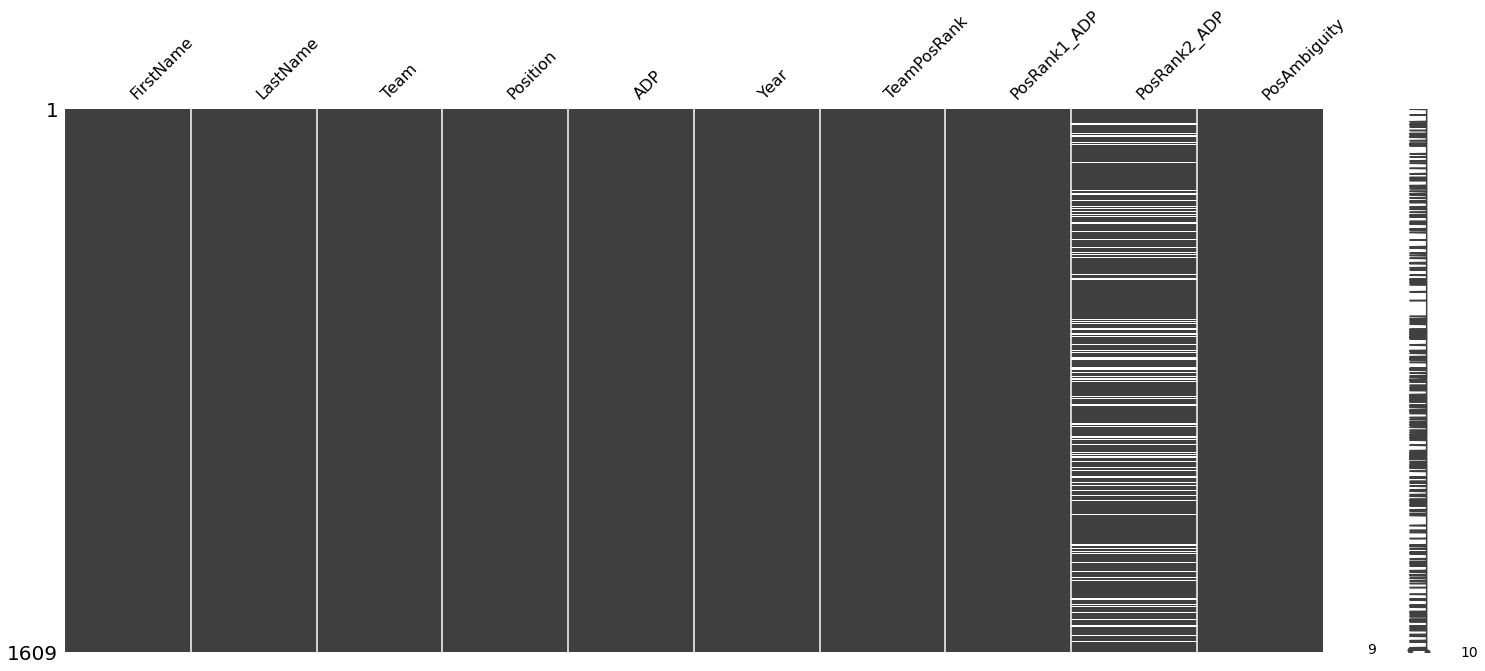

In [156]:
# Checking for missing data
# Some data missing for PosRank2_ADP; will need to work this out before use in ML models
msno.matrix(adp_df)
adp_df.to_csv(file_dest + "/ADP_2013-2021.csv", index=False)


# Web Scraping Season Stats (2013 - 2021)

In [169]:
def season_stats(year):
    '''
    Function to get seasonal stats for players
    '''
    
    # Extract table HTML from input URL
    page = requests.get('https://www.pro-football-reference.com/years/' + str(year) + '/fantasy.htm')
    soup = BeautifulSoup(page.text, 'lxml')
    table = soup.find('table', attrs={'id': 'fantasy'})
    
    # Convert table HTML to pandas df
    df = pd.read_html(str(table))[0]
    
    # Rename columns
    df.columns = df.columns.droplevel(0) # Remove multi-layer header
    df.columns = [
        'Rk', 'PlayerName', 'Team', 'Position', 'Age', 'GamesPlayed', 'GamesStarted', 'PassCmp', 
        'PassAtt', 'PassYds', 'PassTD', 'Int', 'RushAtt', 'RushYds', 'RushYardsPerAtt', 'RushTD', 
        'Tgts', 'Receptions', 'RecYds', 'YardsPerRec', 'RecTD', 'Fmb', 'FL', 'TD', '2PM', '2PP', 
        'FantPt', 'PointsPPR', 'DKPt', 'PointsHalfPPR', 'VBD', 'PosRank', 'OvRank'
    ]

    # Selected relavent columns
    df = df[[
        'PlayerName', 'Team', 'Position', 'Age', 'GamesPlayed', 'RushAtt', 'RushYds', 
        'RushYardsPerAtt', 'RushTD', 'Tgts', 'Receptions', 'RecYds', 'YardsPerRec', 'RecTD', 
        'PointsPPR', 'PointsHalfPPR'
    ]]
    
    df['Year'] = year
    df = df[df.PlayerName != 'Player']
    df = df[(df.Position == 'RB') | (df.Position == 'WR') | (df.Position == 'TE') | (df.Position == 'QB')]
    df = df[(df.Team != '2TM') & (df.Team != '3TM') & (df.Team != '4TM')]
    
    return df


In [211]:
def clean_names_ssn_stats(df):
    '''
    Function to clean player names to make consistent with the ADP data
    '''
    
    # Convert data types
    df = df.astype({'Age': 'int', 'GamesPlayed': 'int', 'PointsPPR': 'float', 'PointsHalfPPR': 'float',
                    'RushAtt': 'int', 'RushYds': 'int', 'RushYardsPerAtt': 'float', 'RushTD': 'int', 
                    'Tgts': 'float', 'Receptions': 'int', 'RecYds': 'int', 'YardsPerRec': 'float', 'RecTD': 'int',})
    df['PPG_PPR'] = round(df.PointsPPR / df.GamesPlayed, 2)
    df['PPG_HalfPPR'] = round(df.PointsHalfPPR / df.GamesPlayed, 2)
    df['TgtsPerGame'] = round(df.Tgts / df.GamesPlayed, 2)
    
    # Split name into columns and edit
    df[['FirstName', 'LastName',]] = df.PlayerName.str.split(" ", n=1, expand=True)
    df['FirstName'] = df['FirstName'].str.replace('[^\w\s]', '', regex=True)
    df['LastName'] = df['LastName'].str.replace('[^\w\s]', '', regex=True)
    df['LastName'] = df['LastName'].str.replace(' II', '', regex=True)             # Edit names for consistency
    df['LastName'] = df['LastName'].str.replace(' III', '', regex=True)            # with naming convention in
    df['LastName'] = df['LastName'].str.replace(' IV', '', regex=True)             # other data sets (no suffix)
    df['LastName'] = df['LastName'].str.replace(' V', '', regex=True)
    df['LastName'] = df['LastName'].str.replace(' Sr', '', regex=True)
    df['LastName'] = df['LastName'].str.replace(' Jr', '', regex=True)
    
    # Reorder columns
    df = df[[
        'FirstName', 'LastName', 'Team', 'Position', 'Year', 'Age', 'GamesPlayed', 'PointsPPR', 
        'PointsHalfPPR', 'PPG_PPR', 'PPG_HalfPPR', 'RushAtt', 'RushYds', 'RushYardsPerAtt', 'RushTD', 
        'Tgts', 'TgtsPerGame', 'Receptions', 'RecYds', 'YardsPerRec', 'RecTD',
    ]]
    
    return df


In [214]:
# Create data frame containing all stats from 2013 to 2021
years = list(np.arange(2013, 2022))
stats_df = [season_stats(year) for year in years] # Scrape all data
stats_df = pd.concat(stats_df)                    # Concatenate data frames from each year
stats_df = clean_names_ssn_stats(stats_df)        # Clean data frame
stats_df.to_csv(file_dest + "/season_statistics_2013-2021.csv", index=False)
stats_df.dtypes


FirstName           object
LastName            object
Team                object
Position            object
Year                 int64
Age                  int64
GamesPlayed          int64
PointsPPR          float64
PointsHalfPPR      float64
PPG_PPR            float64
PPG_HalfPPR        float64
RushAtt              int64
RushYds              int64
RushYardsPerAtt    float64
RushTD               int64
Tgts               float64
TgtsPerGame        float64
Receptions           int64
RecYds               int64
YardsPerRec        float64
RecTD                int64
dtype: object

<AxesSubplot:>

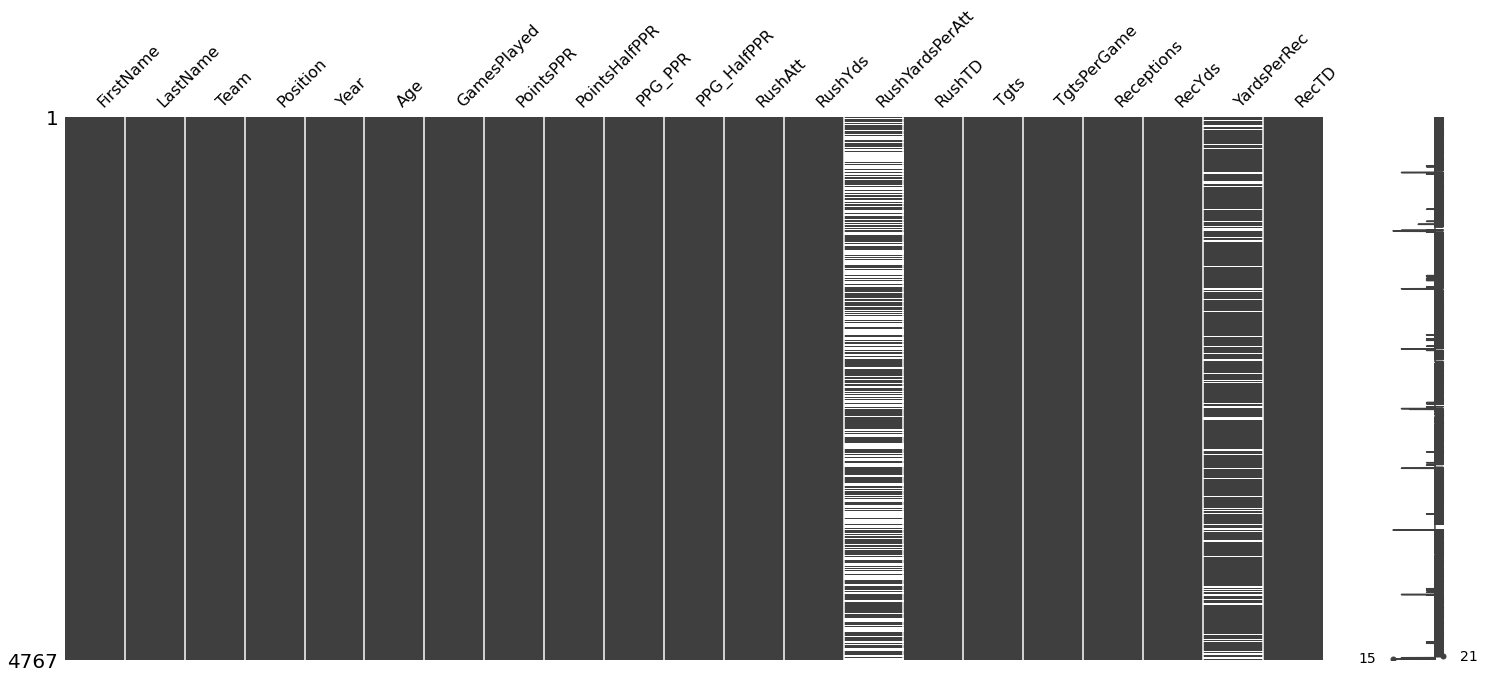

In [213]:
# Checking for missing data
msno.matrix(stats_df)


# Merging ADP & Season Statistics

In [215]:
# Merging the data using "inner" method; will remove players who do not overlap between data sets
all_data = adp_df.merge(stats_df, how="inner")
all_data.to_csv(file_dest + "/ADP&stats_2013-2021.csv", index=False)


<AxesSubplot:>

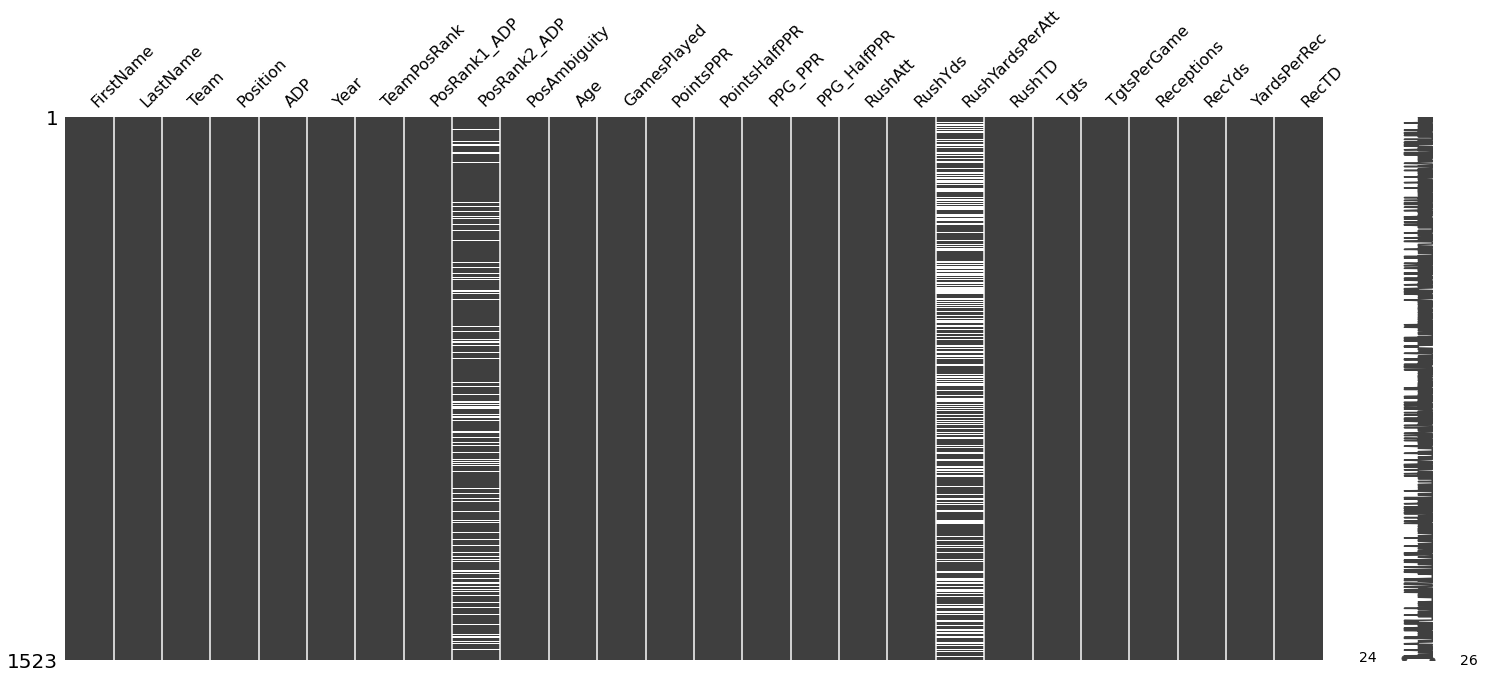

In [216]:
# Checking for missing data - once again missing data for PosRank2_ADP (expected)
msno.matrix(all_data)
